# Lab 2 – Fixed Effects

In [1]:
! pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import compare

import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("/content/panel-for-R.csv")

### Interested in variables: `happy`, `income`, `satfin`

`happy`:
1 – "Very happy";
2 – "Pretty happy";
3 - "Not too happy"

In [15]:
df['happy'].unique()

array([ 2.,  3.,  1., nan])

`income`:
1-12, can be found here: https://gssdataexplorer.norc.org/variables/104/vshow

In [16]:
df['income'].unique()

array([12., nan, 11.,  9.,  1.,  8.,  4., 10.,  7.,  3.,  5.,  6.,  2.])

`satfin`:
1 - "Pretty well satisfied";
2 - "More or less satisfied";
3 - "Not satisfied at all"

In [17]:
df['satfin'].unique()

array([ 2.,  3.,  1., nan])

I want to refactor `happy` and `satfin` so that the levels are reversed, just because it makes more sense to me


In [18]:
# Refactoring "Happy" & "Satfin" Column so:
# 1: Not too happy / Not satisfied at all
# 2: Pretty happy / More or less satisfied
# 3: Very happy / Pretty well satisfied

replacement_map = {
    1: 3,  # Change old 1 to new 3
    3: 1   # Change old 3 to new 1
}

df['happy'] = df['happy'].replace(replacement_map)
df['satfin'] = df['satfin'].replace(replacement_map)

In [19]:
# Filtering just the columns I want
interested_cols = ['idnum', 'panelwave', 'year', 'happy', 'income', 'satfin']
regression_df = df[interested_cols]

There is a persistent pattern of rows in `year` being NA and everything else being NA with it, which can be cause for concern. However, it looks like there is not a significant percentage of missing data, so I will just drop all NA.

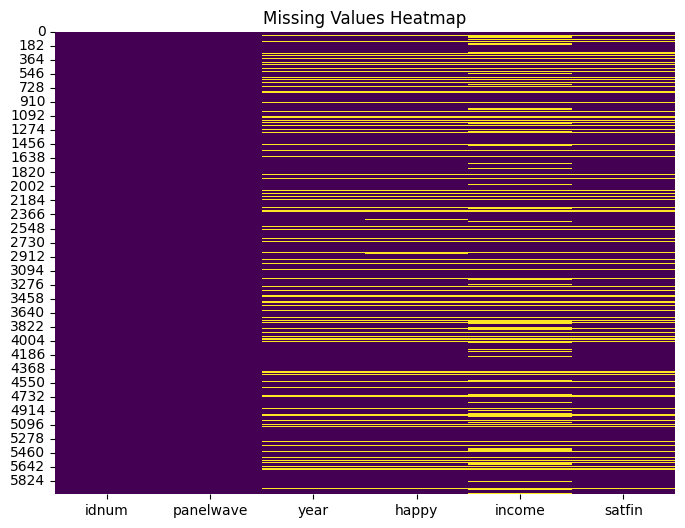

In [20]:
# Investigating missing data
# Create a heatmap of missing values
plt.figure(figsize=(8, 6))
sns.heatmap(regression_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [21]:
regression_df = regression_df.dropna()

### (a) Run an OLS regression, including at least one independent variable and a time variable (as dummies). Explain how you think your independent variable relates to your dependent variable. Interpret your results. Did you find what you expected to find?

**Hypothesis**: I ran a naive OLS regression to predict happiness level `(happy)` using income `(income)` and time fixed effects. I would expect a positive coefficient for income, suggesting that an increase in income is associated with an increase in happiness. This is self-explanatory; when you have more money, you are better able to support yourself and your lifestyle, which I think plays a big role in how happy you are with your life.


**Results:** We see that for every 1 unit increase in income, happiness increases by approximately 0.0374 units (on average), net of time effects, and it is highly statistically significant. This suggests that ON AVERAGE, richer people tend to be happier than poorer people.

In [22]:
# Run an OLS regression without country fixed effects, only using the urban population and year fixed effects
ols_model = smf.ols(formula='happy ~ income + C(year)', data=regression_df).fit()

# Display the summary of the OLS regression
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  happy   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     26.56
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           5.17e-17
Time:                        23:29:31   Log-Likelihood:                -4018.9
No. Observations:                4259   AIC:                             8046.
Df Residuals:                    4255   BIC:                             8071.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.7741      0.050     35.623      0.000       1.676       1.872
C(year)[T.2008.0]    -0.0206      0.022     -0.919      0.358      -0.065       0.023
C(year)[T.2010.0]    -0.0610      0.024     -2.569      0.010      -0.108      -0.014
income                0.0374      0.004      8.607      0.000       0.029       0.046
==============================================================================
Omnibus:                      115.582   Durbin-Watson:                   1.486
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.405
Skew:                          -0.096   Prob(JB):                     4.64e-14
Kurtosis:                       2.444   Cond. No.                         59.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## (b) Then run a fixed effect model version of that OLS model. Interpret your results. Did you find what you expected to find? Why? Why not?

I ran a fixed effects model to account for individual-level and time-level fixed effects, which controls for unobserved heterogeneity across respondents and years. In this FE model, a 1 unit increase in income is associated with a 0.0125 unit increase in happiness, net of time. We see that due to FE controlling for unobserved differences across respondents and time, this coefficient is much smaller than the previous naive model, suggesting that when we look at within-person changes in income, their happiness levels don't change much. In other words, richer people tend to be happier on average, but when the same person's income increases, their happiness doesn't really change much.

Another important note is that the p-value dramatically increases with the FE model (from 0 to 0.2), and our coeff of 0.0125 is no longer significant. This suggests smaller within-person variations of both income and happiness. Since the panel data was from 2006 to 2010, I cannot imagine people's incomes changing that drastically that their happiness level would increase by a significant amount.

In [23]:
# Set the time and entity index
regression_df = regression_df.set_index(['idnum', 'year'])

# Fit the fixed effects model
fixed_effects_model = PanelOLS.from_formula('happy ~ income + EntityEffects + TimeEffects', data=regression_df).fit(cov_type='clustered', cluster_entity=True)

# Display the summary of the regression
print(fixed_effects_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  happy   R-squared:                        0.0015
Estimator:                   PanelOLS   R-squared (Between):              0.1160
No. Observations:                4259   R-squared (Within):               0.0013
Date:                Thu, Nov 06 2025   R-squared (Overall):              0.1142
Time:                        23:29:34   Log-likelihood                   -1610.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.5406
Entities:                        1879   P-value                           0.0600
Avg Obs:                       2.2666   Distribution:                  F(1,2377)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             1.4956
                            

## (c) Then include an additional predictor in your fixed effects model that you think might account for the initial relationship you found between your X and your Y. What effect does that new independent variable have in your new regression?

My chosen additional predictor is `satfin`, which tracks level of financial satisfaction. I thought instead of income being the direct cause for whether you were happy, it must instead be whether you are satisfied with your financial situation that is causing you to either be happy or not. This makes sense as people have subjective views of money.

This is exactly what we see in the model. The relationship between `happy` and `income` gets murkier with a coeff of 0.008 and a monstrous p-value of 0.4. Meanwhile, the coeff for `satfin` is 0.1485 (1 unit increase of `satfin` contributes to a 0.1485 unit increase of `happy`) with a significant p-value of 0.

In other words, when a given person’s income increases, they feel more satisfied with their financial situation, which in turn makes them slightly happier – although income has no significant impact.

In [24]:
# Fit the fixed effects model
fixed_effects_model_with_education = PanelOLS.from_formula('happy ~ income + satfin + EntityEffects + TimeEffects', data=regression_df).fit(cov_type='clustered', cluster_entity=True)

# Display the summary of the regression
print(fixed_effects_model_with_education.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  happy   R-squared:                        0.0307
Estimator:                   PanelOLS   R-squared (Between):              0.3118
No. Observations:                4259   R-squared (Within):               0.0313
Date:                Thu, Nov 06 2025   R-squared (Overall):              0.3055
Time:                        23:29:37   Log-likelihood                   -1547.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      37.639
Entities:                        1879   P-value                           0.0000
Avg Obs:                       2.2666   Distribution:                  F(2,2376)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             16.493
                            